# Phase1

In [ ]:
!pip -q install kagglehub


In [ ]:
import kagglehub
import os, glob

path = kagglehub.dataset_download("orvile/wesad-wearable-stress-affect-detection-dataset")
print("Downloaded to:", path)

# show top-level files
print("Top-level files:", os.listdir(path)[:30])


100%|██████████| 2.43G/2.43G [00:26<00:00, 100MB/s]

Extracting files...


Downloaded to: /root/.cache/kagglehub/datasets/orvile/wesad-wearable-stress-affect-detection-dataset/versions/1
Top-level files: ['WESAD']


In [ ]:
pkl_files = glob.glob(os.path.join(path, "**", "*.pkl"), recursive=True)
print("Number of .pkl files:", len(pkl_files))
print("Example:", pkl_files[:5])


Number of .pkl files: 15
Example: ['/root/.cache/kagglehub/datasets/orvile/wesad-wearable-stress-affect-detection-dataset/versions/1/WESAD/S15/S15.pkl', '/root/.cache/kagglehub/datasets/orvile/wesad-wearable-stress-affect-detection-dataset/versions/1/WESAD/S16/S16.pkl', '/root/.cache/kagglehub/datasets/orvile/wesad-wearable-stress-affect-detection-dataset/versions/1/WESAD/S11/S11.pkl', '/root/.cache/kagglehub/datasets/orvile/wesad-wearable-stress-affect-detection-dataset/versions/1/WESAD/S8/S8.pkl', '/root/.cache/kagglehub/datasets/orvile/wesad-wearable-stress-affect-detection-dataset/versions/1/WESAD/S6/S6.pkl']


In [ ]:
import pickle

# pick one file (change index if needed)
pkl_path = pkl_files[0]
print("Loading:", pkl_path)

with open(pkl_path, "rb") as f:
    data = pickle.load(f, encoding="latin1")

print(data.keys())


Loading: /root/.cache/kagglehub/datasets/orvile/wesad-wearable-stress-affect-detection-dataset/versions/1/WESAD/S15/S15.pkl
dict_keys(['signal', 'label', 'subject'])


In [ ]:
import numpy as np

print("Top keys:", data.keys())
print("Signal blocks:", data["signal"].keys())

for block_name in data["signal"].keys():
    print(f"\n--- {block_name.upper()} channels ---")
    for ch_name, arr in data["signal"][block_name].items():
        arr = np.array(arr)
        print(f"{ch_name:10s} shape={arr.shape}")


Top keys: dict_keys(['signal', 'label', 'subject'])
Signal blocks: dict_keys(['chest', 'wrist'])

--- CHEST channels ---
ACC        shape=(3676400, 3)
ECG        shape=(3676400, 1)
EMG        shape=(3676400, 1)
EDA        shape=(3676400, 1)
Temp       shape=(3676400, 1)
Resp       shape=(3676400, 1)

--- WRIST channels ---
ACC        shape=(168064, 3)
BVP        shape=(336128, 1)
EDA        shape=(21008, 1)
TEMP       shape=(21008, 1)


Label values & counts: {np.int64(0): np.int64(1457401), np.int64(1): np.int64(822500), np.int64(2): np.int64(480200), np.int64(3): np.int64(260400), np.int64(4): np.int64(555799), np.int64(5): np.int64(35000), np.int64(6): np.int64(32900), np.int64(7): np.int64(32200)}


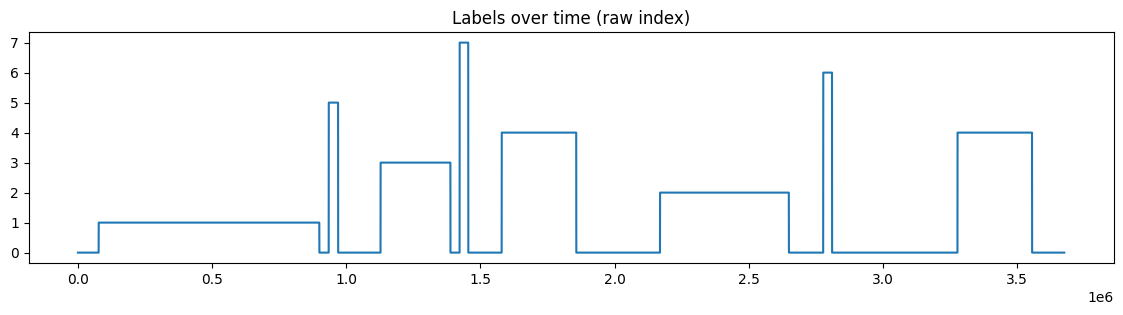

In [ ]:
labels = np.array(data["label"]).astype(int).flatten()
u, c = np.unique(labels, return_counts=True)
print("Label values & counts:", dict(zip(u, c)))

import matplotlib.pyplot as plt
plt.figure(figsize=(14,3))
plt.plot(labels)
plt.title("Labels over time (raw index)")
plt.show()


1 → baseline (calm)

2 → stress

3 → amusement (positive arousal)

0 → transition / undefined

5,6,7 → stress sub-phases (speech, math, etc.)

We are given ground-truth labels in time.

In [ ]:
def fetch(sig_block, channel):
    if sig_block in data["signal"] and channel in data["signal"][sig_block]:
        x = np.array(data["signal"][sig_block][channel])
        if x.ndim == 2 and x.shape[1] == 1:
            x = x[:,0]
        return x
    return None

ecg = fetch("chest", "ECG")
ecg = fetch("chest", "ECG")

eda = fetch("wrist", "EDA")
if eda is None:
    eda = fetch("chest", "EDA")

temp = fetch("wrist", "TEMP")
if temp is None:
    temp = fetch("chest", "Temp")


print("ECG:", None if ecg is None else ecg.shape)
print("EDA:", None if eda is None else eda.shape)
print("TEMP:", None if temp is None else temp.shape)


ECG: (3676400,)
EDA: (21008,)
TEMP: (21008,)


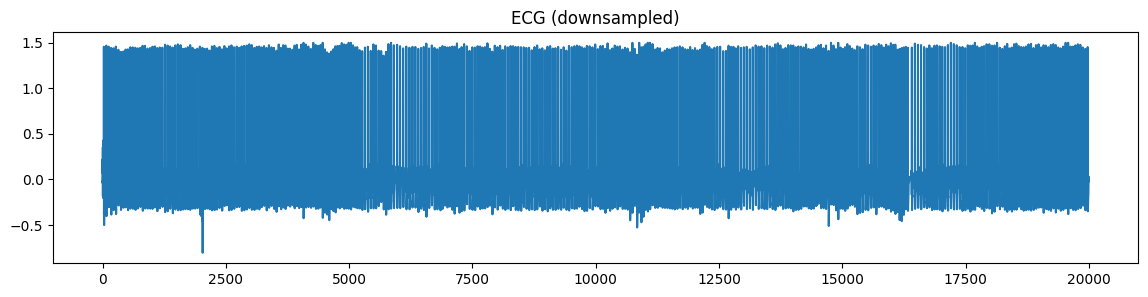

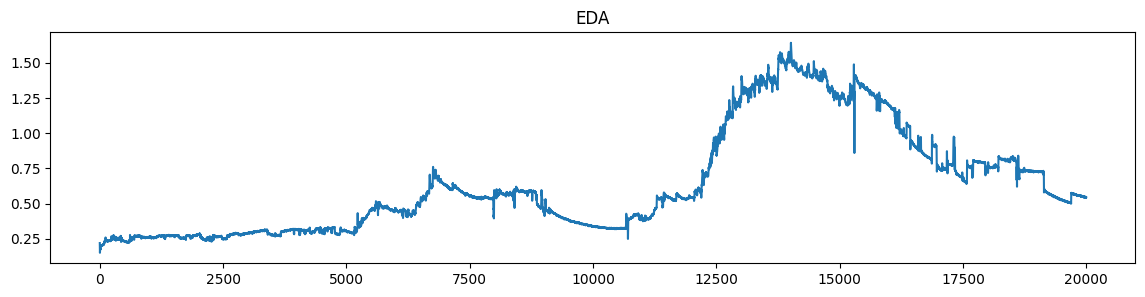

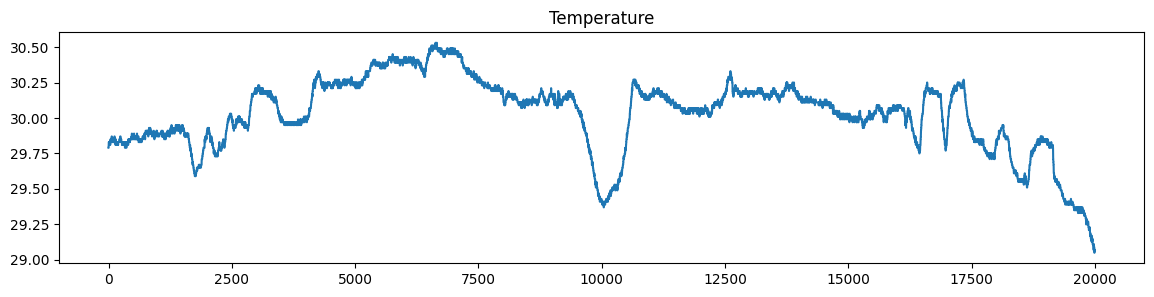

In [ ]:
def plot_signal(x, title, ds=1, n=20000):
    if x is None:
        print(f"Missing {title}")
        return
    x = x[::ds]
    x = x[:n]
    plt.figure(figsize=(14,3))
    plt.plot(x)
    plt.title(title)
    plt.show()

plot_signal(ecg, "ECG (downsampled)", ds=10)
plot_signal(eda, "EDA", ds=1)
plot_signal(temp, "Temperature", ds=1)


Top plot:
“Do we have a long, stable, uninterrupted ECG recording?”

Answer from this plot: yes ✅

middle plot:

Why this plot is a green flag 🚦

EDA is:

Smooth

Non-noisy

Shows large-scale structure

That means:

The wrist sensor worked

The subject actually reacted to tasks

Stress is detectable from physiology

If this plot were flat → your whole project would be in danger.

bottom plot

What your plot shows



*   Very smooth curves
*   Gradual rises and falls
*   One clear dip (around the middle)
*   No high-frequency noise

This is exactly what we want.

Why temperature matters even if it looks boring

Temperature:
*   Is not a strong instant marker
*   But very useful combined with EDA
*   Helps distinguish stress from excitement/amusement








In [ ]:
print("labels length:", len(labels))
print("ecg length:", len(ecg))
print("eda length:", len(eda))
print("temp length:", len(temp))


labels length: 3676400
ecg length: 3676400
eda length: 21008
temp length: 21008


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

FS_ECG = 700
FS_EDA = 4
FS_TEMP = 4

labels_chest = np.array(data["label"]).astype(int).flatten()

# Merge stress sub-phases into "stress"
# baseline=1, amusement=3
# stress = {2,5,6,7}  (common in WESAD variants)
def map_to_3class(y):
    if y == 1:
        return 1   # baseline
    if y == 3:
        return 3   # amusement
    if y in [2,5,6,7]:
        return 2   # stress
    return 0       # undefined / other (e.g., transitions, meditation if present)

labels3_chest = np.array([map_to_3class(y) for y in labels_chest], dtype=int)

# Time axes
t_chest = np.arange(len(labels_chest)) / FS_ECG


In [ ]:
def resample_labels_to_fs(labels_at_700hz, fs_from, fs_to, n_to):
    # For each sample in the low-rate signal, find corresponding index in high-rate label stream
    idx = (np.arange(n_to) * fs_from / fs_to).astype(int)
    idx = np.clip(idx, 0, len(labels_at_700hz)-1)
    return labels_at_700hz[idx]

# Make 4 Hz labels aligned to EDA/TEMP
labels3_eda = resample_labels_to_fs(labels3_chest, FS_ECG, FS_EDA, len(eda))
labels3_temp = resample_labels_to_fs(labels3_chest, FS_ECG, FS_TEMP, len(temp))

t_eda = np.arange(len(eda)) / FS_EDA
t_temp = np.arange(len(temp)) / FS_TEMP


In [ ]:
def shade_regions(ax, t, labels3):
    # Shade baseline (1), stress (2), amusement (3)
    # We only shade where labels3 != 0
    regions = []
    start = 0
    cur = labels3[0]
    for i in range(1, len(labels3)):
        if labels3[i] != cur:
            regions.append((start, i-1, cur))
            start = i
            cur = labels3[i]
    regions.append((start, len(labels3)-1, cur))

    for s, e, lab in regions:
        if lab == 0:
            continue
        # x-span in time
        ax.axvspan(t[s], t[e], alpha=0.15)

    # Legend mapping (text only; shading is neutral)
    ax.text(0.01, 0.95, "Shading: baseline/stress/amusement (labels!=0)", transform=ax.transAxes,
            va="top", fontsize=9)


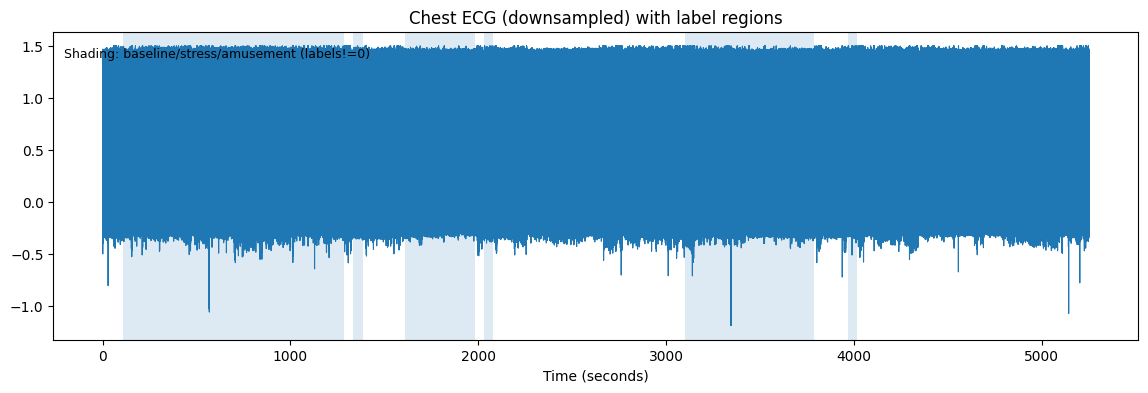

In [ ]:
# Downsample ECG for plotting speed
ds = 10
ecg_plot = ecg[::ds]
t_ecg_plot = t_chest[::ds]
labels3_plot = labels3_chest[::ds]

plt.figure(figsize=(14,4))
ax = plt.gca()
ax.plot(t_ecg_plot, ecg_plot, linewidth=0.8)
shade_regions(ax, t_ecg_plot, labels3_plot)
ax.set_title("Chest ECG (downsampled) with label regions")
ax.set_xlabel("Time (seconds)")
plt.show()


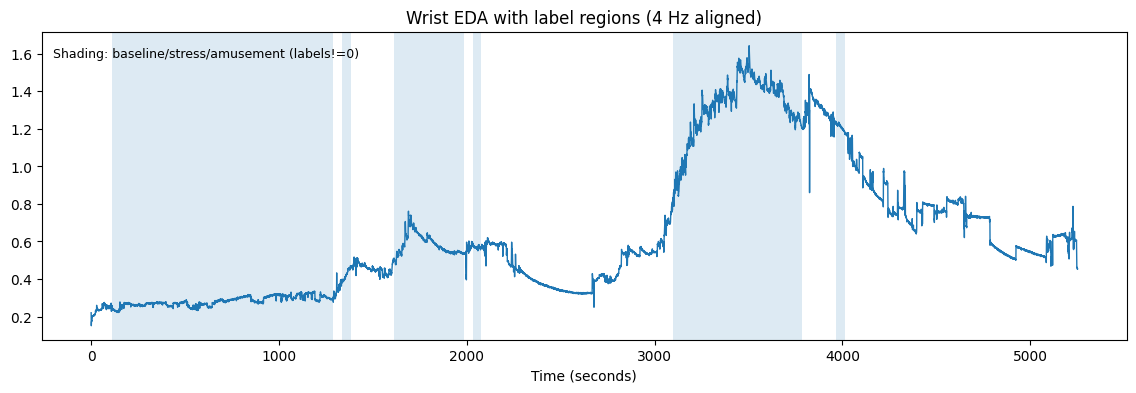

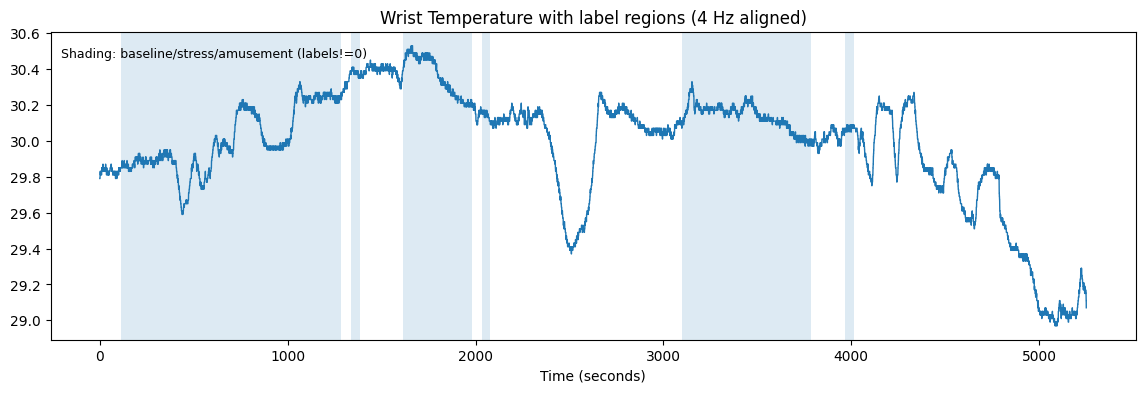

In [ ]:
plt.figure(figsize=(14,4))
ax = plt.gca()
ax.plot(t_eda, eda, linewidth=1)
shade_regions(ax, t_eda, labels3_eda)
ax.set_title("Wrist EDA with label regions (4 Hz aligned)")
ax.set_xlabel("Time (seconds)")
plt.show()

plt.figure(figsize=(14,4))
ax = plt.gca()
ax.plot(t_temp, temp, linewidth=1)
shade_regions(ax, t_temp, labels3_temp)
ax.set_title("Wrist Temperature with label regions (4 Hz aligned)")
ax.set_xlabel("Time (seconds)")
plt.show()


# Phase 2


Install + imports

In [ ]:
!pip -q install kagglehub

import os, glob, pickle
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


1) Download + locate subject PKLs

In [ ]:
import kagglehub

path = kagglehub.dataset_download("orvile/wesad-wearable-stress-affect-detection-dataset")
print("Downloaded to:", path)

pkl_files = sorted(glob.glob(os.path.join(path, "**", "S*.pkl"), recursive=True))
print("Found PKLs:", len(pkl_files))
print(pkl_files[:3])


Downloaded to: /root/.cache/kagglehub/datasets/orvile/wesad-wearable-stress-affect-detection-dataset/versions/1
Found PKLs: 15
['/root/.cache/kagglehub/datasets/orvile/wesad-wearable-stress-affect-detection-dataset/versions/1/WESAD/S10/S10.pkl', '/root/.cache/kagglehub/datasets/orvile/wesad-wearable-stress-affect-detection-dataset/versions/1/WESAD/S11/S11.pkl', '/root/.cache/kagglehub/datasets/orvile/wesad-wearable-stress-affect-detection-dataset/versions/1/WESAD/S13/S13.pkl']


2) Helpers: load subject + merge labels into 3 classes

In [ ]:
LABEL_BASELINE = 1
LABEL_AMUSE = 3
LABEL_STRESS_SET = {2,5,6,7}

def map_label_3class(lbl):
    # returns: 0=ignore, 1=baseline, 2=stress, 3=amusement
    if lbl == LABEL_BASELINE:
        return 1
    if lbl in LABEL_STRESS_SET:
        return 2
    if lbl == LABEL_AMUSE:
        return 3
    return 0  # ignore transitions/others

def load_subject(pkl_path):
    sid = os.path.splitext(os.path.basename(pkl_path))[0]  # e.g., "S14"
    with open(pkl_path, "rb") as f:
        d = pickle.load(f, encoding="latin1")
    return sid, d

def resample_labels_to_4hz(labels_700hz, target_len_4hz):
    # labels aligned with chest ECG (700 Hz); convert to 4 Hz by picking indices
    idx = np.linspace(0, len(labels_700hz)-1, target_len_4hz).astype(int)
    return labels_700hz[idx]


3) Build a 4 Hz dataframe per subject (EDA + TEMP + label)

In [ ]:
def subject_to_df_4hz(d):
    wrist_eda = d["signal"]["wrist"]["EDA"].reshape(-1)
    wrist_temp = d["signal"]["wrist"]["TEMP"].reshape(-1)

    L = len(wrist_eda)  # 4 Hz timeline length
    labels_700 = d["label"].reshape(-1)
    labels_4 = resample_labels_to_4hz(labels_700, L)

    y3 = np.array([map_label_3class(x) for x in labels_4], dtype=int)

    df = pd.DataFrame({
        "eda": wrist_eda,
        "temp": wrist_temp,
        "y": y3
    })
    return df


4) Windowing + feature extraction (simple but solid)

In [ ]:
def window_features_eda_temp(x_eda, x_temp, fs=4):
    # EDA features
    eda_mean = np.mean(x_eda)
    eda_std  = np.std(x_eda)
    eda_min  = np.min(x_eda)
    eda_max  = np.max(x_eda)
    eda_range = eda_max - eda_min

    # slope (simple linear trend)
    t = np.arange(len(x_eda)) / fs
    eda_slope = np.polyfit(t, x_eda, 1)[0]

    # TEMP features
    temp_mean = np.mean(x_temp)
    temp_std  = np.std(x_temp)
    temp_min  = np.min(x_temp)
    temp_max  = np.max(x_temp)
    temp_range = temp_max - temp_min
    temp_slope = np.polyfit(t, x_temp, 1)[0]

    # temp delta (end-start)
    temp_delta = x_temp[-1] - x_temp[0]

    return [
        eda_mean, eda_std, eda_min, eda_max, eda_range, eda_slope,
        temp_mean, temp_std, temp_min, temp_max, temp_range, temp_slope, temp_delta
    ]

def make_windows(df, subject_id, win_sec=60, step_sec=30, fs=4):
    win = int(win_sec * fs)
    step = int(step_sec * fs)

    X, y, groups, meta = [], [], [], []

    for start in range(0, len(df) - win + 1, step):
        chunk = df.iloc[start:start+win]
        # ignore windows dominated by "0" labels (transitions/unknown)
        y_vals = chunk["y"].values
        valid = y_vals[y_vals != 0]
        if len(valid) < 0.8 * len(y_vals):
            continue

        # window label = majority vote among valid labels
        labels, counts = np.unique(valid, return_counts=True)
        y_win = labels[np.argmax(counts)]

        feats = window_features_eda_temp(chunk["eda"].values, chunk["temp"].values, fs=fs)

        X.append(feats)
        y.append(y_win)
        groups.append(subject_id)
        meta.append({"subject": subject_id, "start_idx": start, "end_idx": start+win})

    return np.array(X, dtype=float), np.array(y, dtype=int), np.array(groups), meta


5) Build dataset across all subjects (creates X, y, groups, all_meta)

In [ ]:


all_X, all_y, all_groups, all_meta = [], [], [], []

print("PKL files:", len(pkl_files))

for p in pkl_files:
    sid, d = load_subject(p)
    df = subject_to_df_4hz(d)

    X_s, y_s, g_s, meta_s = make_windows(df, sid, win_sec=60, step_sec=30, fs=4)

    print(f"{sid}: windows = {len(X_s)}")

    if len(X_s) == 0:
        continue

    all_X.append(X_s)
    all_y.append(y_s)
    all_groups.append(g_s)
    all_meta.extend(meta_s)

print("Subjects kept:", len(all_y))

X = np.vstack(all_X)
y = np.concatenate(all_y)
groups = np.concatenate(all_groups)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("groups shape:", groups.shape)
print("y distribution:", dict(zip(*np.unique(y, return_counts=True))))


PKL files: 15
S10: windows = 73
S11: windows = 72
S13: windows = 70
S14: windows = 72
S15: windows = 71
S16: windows = 74
S17: windows = 75
S2: windows = 69
S3: windows = 72
S4: windows = 68
S5: windows = 72
S6: windows = 73
S7: windows = 72
S8: windows = 71
S9: windows = 72
Subjects kept: 15
X shape: (1076, 13)
y shape: (1076,)
groups shape: (1076,)
y distribution: {np.int64(1): np.int64(570), np.int64(2): np.int64(339), np.int64(3): np.int64(167)}


6) Train + evaluate properly (by-subject split)

In [ ]:
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

gkf = GroupKFold(n_splits=5)

all_preds = np.zeros_like(y)
all_proba = np.zeros((len(y), 3))  # classes are {1,2,3} but sklearn indexes them

for fold, (tr, te) in enumerate(gkf.split(X, y, groups)):
    clf.fit(X[tr], y[tr])
    pred = clf.predict(X[te])
    proba = clf.predict_proba(X[te])

    all_preds[te] = pred
    all_proba[te] = proba

print(classification_report(y, all_preds, target_names=["baseline(1)", "stress(2)", "amusement(3)"]))
print("Confusion matrix:\n", confusion_matrix(y, all_preds))


              precision    recall  f1-score   support

 baseline(1)       0.79      0.50      0.61       570
   stress(2)       0.61      0.63      0.62       339
amusement(3)       0.22      0.48      0.30       167

    accuracy                           0.54      1076
   macro avg       0.54      0.54      0.51      1076
weighted avg       0.64      0.54      0.57      1076

Confusion matrix:
 [[286  95 189]
 [ 33 213  93]
 [ 43  44  80]]


7) Produce P(stress) over time (per subject)

In [ ]:
# Map class index -> label
class_order = clf.named_steps["lr"].classes_
stress_class_index = int(np.where(class_order == 2)[0][0])

results = []
fs = 4
win_sec = 60
step_sec = 30
step = step_sec  # in seconds

for i, m in enumerate(all_meta):
    sid = m["subject"]
    start_sec = (m["start_idx"] / fs)
    p_stress = all_proba[i, stress_class_index]
    results.append([sid, start_sec, p_stress, int(all_preds[i]), int(y[i])])

res_df = pd.DataFrame(results, columns=["subject", "start_sec", "p_stress", "y_pred", "y_true"])
res_df.head()


,subject,start_sec,p_stress,y_pred,y_true
0,S10,90.0,0.363866,1,1
1,S10,120.0,0.127621,3,1
2,S10,150.0,0.099677,3,1
3,S10,180.0,0.119237,3,1
4,S10,210.0,0.119978,3,1


Now we have done Logistic regression with 3 outputs (baseline, amusement and stress)

Next we will use LR with binary output stress or no

In [1]:
# ============================================
# Phase 2 (Improved) — Binary Stress Pipeline
# Classical ML baseline + upgrades (LR → SVM/RF)
# Uses subject-wise CV (GroupKFold) and outputs P(stress)
# ============================================

!pip -q install kagglehub

import os, glob, pickle
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


# ----------------------------
# 0) Download + find PKLs
# ----------------------------
import kagglehub
path = kagglehub.dataset_download("orvile/wesad-wearable-stress-affect-detection-dataset")
pkl_files = sorted(glob.glob(os.path.join(path, "**", "S*.pkl"), recursive=True))
print("Downloaded to:", path)
print("Found PKLs:", len(pkl_files))
print("Example:", pkl_files[:3])


# ----------------------------
# 1) Load helpers
# ----------------------------
LABEL_STRESS_SET = {2, 5, 6, 7}
LABEL_NONSTRESS_SET = {1, 3}   # baseline + amusement
IGNORE_SET = {0, 4}

def load_subject(pkl_path):
    sid = os.path.splitext(os.path.basename(pkl_path))[0]  # "S14"
    with open(pkl_path, "rb") as f:
        d = pickle.load(f, encoding="latin1")
    return sid, d

def resample_labels_to_len(labels_src, target_len):
    idx = np.linspace(0, len(labels_src)-1, target_len).astype(int)
    return labels_src[idx]

def map_label_binary(lbl):
    if lbl in LABEL_STRESS_SET:
        return 1
    if lbl in LABEL_NONSTRESS_SET:
        return 0
    return -1  # ignore

def subject_to_df_4hz_binary(d):
    eda = d["signal"]["wrist"]["EDA"].reshape(-1)
    temp = d["signal"]["wrist"]["TEMP"].reshape(-1)
    L = len(eda)

    labels_700 = d["label"].reshape(-1)
    labels_4 = resample_labels_to_len(labels_700, L)
    y = np.array([map_label_binary(x) for x in labels_4], dtype=int)

    return pd.DataFrame({"eda": eda, "temp": temp, "y": y})


# ----------------------------
# 2) Feature extraction (baseline + EDA dynamics upgrade)
# ----------------------------
def count_peaks_simple(x, min_delta=0.01):
    """
    Lightweight peak counter (no scipy). Counts local maxima that exceed neighbors by min_delta.
    Works okay for a baseline; you can tune min_delta later.
    """
    if len(x) < 3:
        return 0
    peaks = 0
    for i in range(1, len(x)-1):
        if x[i] > x[i-1] + min_delta and x[i] > x[i+1] + min_delta:
            peaks += 1
    return peaks

def window_features_eda_temp(x_eda, x_temp, fs=4):
    # EDA basic
    eda_mean = np.mean(x_eda)
    eda_std  = np.std(x_eda)
    eda_min  = np.min(x_eda)
    eda_max  = np.max(x_eda)
    eda_range = eda_max - eda_min

    # EDA dynamics (cheap but useful)
    d_eda = np.diff(x_eda)
    eda_absdiff_mean = np.mean(np.abs(d_eda)) if len(d_eda) else 0.0
    eda_posdiff_mean = np.mean(d_eda[d_eda > 0]) if np.any(d_eda > 0) else 0.0
    eda_peaks = count_peaks_simple(x_eda, min_delta=np.std(x_eda) * 0.1 if np.std(x_eda) > 0 else 0.01)

    # Trend (slope)
    t = np.arange(len(x_eda)) / fs
    eda_slope = np.polyfit(t, x_eda, 1)[0]

    # TEMP
    temp_mean = np.mean(x_temp)
    temp_std  = np.std(x_temp)
    temp_min  = np.min(x_temp)
    temp_max  = np.max(x_temp)
    temp_range = temp_max - temp_min
    temp_slope = np.polyfit(t, x_temp, 1)[0]
    temp_delta = x_temp[-1] - x_temp[0]

    return [
        eda_mean, eda_std, eda_min, eda_max, eda_range, eda_slope,
        eda_absdiff_mean, eda_posdiff_mean, eda_peaks,
        temp_mean, temp_std, temp_min, temp_max, temp_range, temp_slope, temp_delta
    ]


# ----------------------------
# 3) Windowing
# ----------------------------
def make_windows_binary(df, subject_id, win_sec=60, step_sec=30, fs=4, valid_ratio=0.8):
    win = int(win_sec * fs)
    step = int(step_sec * fs)

    X, y, groups, meta = [], [], [], []

    for start in range(0, len(df) - win + 1, step):
        chunk = df.iloc[start:start+win]
        y_vals = chunk["y"].values
        valid = y_vals[y_vals != -1]

        if len(valid) < valid_ratio * len(y_vals):
            continue

        # majority vote for binary
        y_win = int(np.round(np.mean(valid)))

        feats = window_features_eda_temp(chunk["eda"].values, chunk["temp"].values, fs=fs)
        X.append(feats)
        y.append(y_win)
        groups.append(subject_id)
        meta.append({"subject": subject_id, "start_idx": start, "end_idx": start+win})

    return np.array(X, float), np.array(y, int), np.array(groups), meta


# ----------------------------
# 4) Build dataset across subjects
# ----------------------------
def build_dataset(win_sec=60, step_sec=30, valid_ratio=0.8):
    all_X, all_y, all_groups, all_meta = [], [], [], []

    for p in pkl_files:
        sid, d = load_subject(p)
        df = subject_to_df_4hz_binary(d)
        X_s, y_s, g_s, meta_s = make_windows_binary(
            df, sid, win_sec=win_sec, step_sec=step_sec, fs=4, valid_ratio=valid_ratio
        )
        if len(X_s) == 0:
            continue
        all_X.append(X_s)
        all_y.append(y_s)
        all_groups.append(g_s)
        all_meta.extend(meta_s)

    X = np.vstack(all_X)
    y = np.concatenate(all_y)
    groups = np.concatenate(all_groups)
    return X, y, groups, all_meta

X, y, groups, meta = build_dataset(win_sec=60, step_sec=30, valid_ratio=0.8)
print("X shape:", X.shape)
print("y distribution:", dict(zip(*np.unique(y, return_counts=True))))
print("subjects:", len(np.unique(groups)))


# ----------------------------
# 5) Evaluation utility (GroupKFold)
# ----------------------------
def eval_model(model, X, y, groups, model_name="model"):
    gkf = GroupKFold(n_splits=5)

    all_preds = np.zeros_like(y)
    all_proba = np.zeros(len(y), dtype=float)  # P(stress)

    for fold, (tr, te) in enumerate(gkf.split(X, y, groups)):
        model.fit(X[tr], y[tr])
        all_preds[te] = model.predict(X[te])

        # probability for class 1 (stress)
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X[te])
            # column index for class 1
            cls = model.named_steps[list(model.named_steps.keys())[-1]].classes_ if isinstance(model, Pipeline) else model.classes_
            idx1 = int(np.where(cls == 1)[0][0])
            all_proba[te] = proba[:, idx1]
        else:
            # for models that don't have predict_proba, fallback to decision_function scaled to 0..1
            scores = model.decision_function(X[te])
            all_proba[te] = 1 / (1 + np.exp(-scores))

    print("\n==============================")
    print("Model:", model_name)
    print("==============================")
    print(classification_report(y, all_preds, target_names=["non-stress(0)", "stress(1)"]))
    print("Confusion matrix:\n", confusion_matrix(y, all_preds))

    try:
        auc = roc_auc_score(y, all_proba)
        print("ROC-AUC:", round(auc, 4))
    except Exception as e:
        print("ROC-AUC not computed:", e)

    return all_preds, all_proba


# ----------------------------
# 6) Model 1: Logistic Regression (baseline)
# ----------------------------
lr_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

lr_preds, lr_pstress = eval_model(lr_model, X, y, groups, model_name="Logistic Regression (binary)")


# ----------------------------
# 7) If LR still weak: Model 2 (SVM RBF) + Model 3 (Random Forest)
# Uncomment when needed
# ----------------------------

# svm_model = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", SVC(kernel="rbf", class_weight="balanced", probability=True))
# ])
# svm_preds, svm_pstress = eval_model(svm_model, X, y, groups, model_name="SVM RBF (binary)")

# rf_model = RandomForestClassifier(
#     n_estimators=400,
#     max_depth=None,
#     min_samples_leaf=3,
#     class_weight="balanced_subsample",
#     random_state=42,
#     n_jobs=-1
# )
# rf_preds, rf_pstress = eval_model(rf_model, X, y, groups, model_name="Random Forest (binary)")


# ----------------------------
# 8) Risk Index from P(stress) (baseline + smoothed)
# ----------------------------
def ema(x, alpha=0.2):
    y = np.zeros_like(x, dtype=float)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1 - alpha) * y[i-1]
    return y

# Build a results dataframe for LR probabilities per window
# meta[i] corresponds to row i in X/y construction order
fs = 4
rows = []
for i, m in enumerate(meta):
    start_sec = m["start_idx"] / fs
    rows.append([m["subject"], start_sec, int(y[i]), float(lr_pstress[i])])

res_df = pd.DataFrame(rows, columns=["subject", "start_sec", "y_true", "p_stress"])
res_df = res_df.sort_values(["subject", "start_sec"]).reset_index(drop=True)

# Add smoothed risk per subject
res_df["risk_raw"] = res_df["p_stress"]
res_df["risk_ema"] = 0.0

for sid in res_df["subject"].unique():
    idx = res_df["subject"] == sid
    res_df.loc[idx, "risk_ema"] = ema(res_df.loc[idx, "p_stress"].values, alpha=0.2)

res_df.head()


Using Colab cache for faster access to the 'wesad-wearable-stress-affect-detection-dataset' dataset.
Downloaded to: /kaggle/input/wesad-wearable-stress-affect-detection-dataset
Found PKLs: 15
Example: ['/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S10/S10.pkl', '/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S11/S11.pkl', '/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD/S13/S13.pkl']
X shape: (1076, 16)
y distribution: {np.int64(0): np.int64(737), np.int64(1): np.int64(339)}
subjects: 15

Model: Logistic Regression (binary)
               precision    recall  f1-score   support

non-stress(0)       0.90      0.78      0.83       737
    stress(1)       0.63      0.81      0.71       339

     accuracy                           0.79      1076
    macro avg       0.76      0.79      0.77      1076
 weighted avg       0.81      0.79      0.79      1076

Confusion matrix:
 [[573 164]
 [ 64 275]]
ROC-AUC: 0.8447


,subject,start_sec,y_true,p_stress,risk_raw,risk_ema
0,S10,90.0,0,0.723188,0.723188,0.723188
1,S10,120.0,0,0.416127,0.416127,0.661776
2,S10,150.0,0,0.103995,0.103995,0.550220
3,S10,180.0,0,0.139286,0.139286,0.468033
4,S10,210.0,0,0.148470,0.148470,0.404120


In [4]:
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# IMPORTANT: your group labels are named "groups" (from build_dataset)
# If you prefer the name "subjects", just uncomment the next line:
# subjects = groups

gkf = GroupKFold(n_splits=5)

def run_groupkfold_eval(model, X, y, groups, name):
    all_pred = np.zeros_like(y)
    all_prob = np.zeros(len(y), dtype=float)

    for tr, te in gkf.split(X, y, groups=groups):
        model.fit(X[tr], y[tr])
        all_pred[te] = model.predict(X[te])

        if hasattr(model, "predict_proba"):
            all_prob[te] = model.predict_proba(X[te])[:, 1]
        else:
            scores = model.decision_function(X[te])
            all_prob[te] = 1 / (1 + np.exp(-scores))

    print("\n" + "="*40)
    print("Model:", name)
    print("="*40)
    print(classification_report(y, all_pred, target_names=["non-stress(0)", "stress(1)"]))
    print("Confusion matrix:\n", confusion_matrix(y, all_pred))
    print("ROC-AUC:", round(roc_auc_score(y, all_prob), 4))

    return all_pred, all_prob

# 1) SVM (RBF)
svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=42))
])
svm_pred, svm_p = run_groupkfold_eval(svm_model, X, y, groups, "SVM (RBF, balanced)")

# 2) Random Forest
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_pred, rf_p = run_groupkfold_eval(rf_model, X, y, groups, "Random Forest (balanced)")

# 3) Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_pred, gb_p = run_groupkfold_eval(gb_model, X, y, groups, "Gradient Boosting")



Model: SVM (RBF, balanced)
               precision    recall  f1-score   support

non-stress(0)       0.90      0.87      0.89       737
    stress(1)       0.74      0.78      0.76       339

     accuracy                           0.85      1076
    macro avg       0.82      0.83      0.82      1076
 weighted avg       0.85      0.85      0.85      1076

Confusion matrix:
 [[644  93]
 [ 73 266]]
ROC-AUC: 0.8885

Model: Random Forest (balanced)
               precision    recall  f1-score   support

non-stress(0)       0.88      0.88      0.88       737
    stress(1)       0.74      0.75      0.75       339

     accuracy                           0.84      1076
    macro avg       0.81      0.81      0.81      1076
 weighted avg       0.84      0.84      0.84      1076

Confusion matrix:
 [[649  88]
 [ 85 254]]
ROC-AUC: 0.8735

Model: Gradient Boosting
               precision    recall  f1-score   support

non-stress(0)       0.88      0.84      0.86       737
    stress(1)       

In [7]:
# ---- XGBoost model (add after SVM/RF) ----
!pip -q install xgboost

import numpy as np
from xgboost import XGBClassifier

# Handle class imbalance: scale_pos_weight = (#neg / #pos)
neg = np.sum(y == 0)
pos = np.sum(y == 1)
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

xgb_model = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=3,                 # conservative to avoid overfit
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    min_child_weight=1,
    gamma=0.0,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

xgb_pred, xgb_p = run_groupkfold_eval(xgb_model, X, y, groups, "XGBoost (conservative)")


scale_pos_weight: 2.174041297935103

Model: XGBoost (conservative)
               precision    recall  f1-score   support

non-stress(0)       0.90      0.83      0.87       737
    stress(1)       0.69      0.81      0.74       339

     accuracy                           0.82      1076
    macro avg       0.80      0.82      0.80      1076
 weighted avg       0.84      0.82      0.83      1076

Confusion matrix:
 [[612 125]
 [ 65 274]]
ROC-AUC: 0.8799


# Phase 3

Calculating risk index

In [11]:
import numpy as np
import pandas as pd

# Build per-window results (for ALL subjects)
res_df = pd.DataFrame({
    "subject": [m["subject"] for m in meta],
    "start_sec": [m["start_idx"]/4 for m in meta],  # fs=4
    "y_true": y.astype(int),
    "p_stress": svm_p.astype(float)
}).sort_values(["subject", "start_sec"]).reset_index(drop=True)

def ema_time_based(p, dt_sec=30, tau_sec=300):
    alpha = 1 - np.exp(-dt_sec / tau_sec)
    out = np.zeros_like(p, dtype=float)
    out[0] = p[0]
    for i in range(1, len(p)):
        out[i] = alpha * p[i] + (1 - alpha) * out[i-1]
    return out

def risk_from_smoothed(p_smooth, theta=0.5):
    return np.clip((p_smooth - theta) / (1 - theta), 0, 1)

DT = 30
TAU = 300
THETA = 0.5

res_df["p_smooth"] = 0.0
res_df["risk_index"] = 0.0

for sid, sub_df in res_df.groupby("subject", sort=False):
    p = sub_df["p_stress"].values
    p_smooth = ema_time_based(p, dt_sec=DT, tau_sec=TAU)
    risk = risk_from_smoothed(p_smooth, theta=THETA)
    res_df.loc[sub_df.index, "p_smooth"] = p_smooth
    res_df.loc[sub_df.index, "risk_index"] = risk

# Show only the subjects you want
subjects_show = ["S7", "S10"]


res_df_filtered = res_df[res_df["subject"].isin(subjects_show)].copy()
res_df_filtered = res_df_filtered.sort_values(["subject", "start_sec"])

# Show first 10 windows from EACH subject
res_df_filtered.groupby("subject").head(10)




,subject,start_sec,y_true,p_stress,p_smooth,risk_index
0,S10,90.0,0,0.690917,0.690917,0.381833
1,S10,120.0,0,0.123676,0.636937,0.273873
2,S10,150.0,0,0.031314,0.579304,0.158608
3,S10,180.0,0,0.034762,0.527484,0.054968
4,S10,210.0,0,0.036480,0.480759,0.000000
5,S10,240.0,0,0.066298,0.441318,0.000000
6,S10,270.0,0,0.167713,0.415281,0.000000
7,S10,300.0,0,0.068268,0.382258,0.000000
8,S10,330.0,0,0.071228,0.352660,0.000000
9,S10,360.0,0,0.075726,0.326306,0.000000


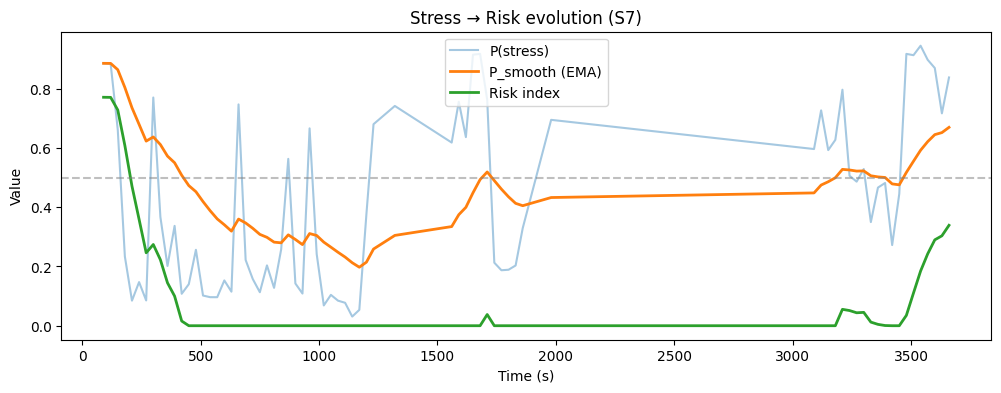

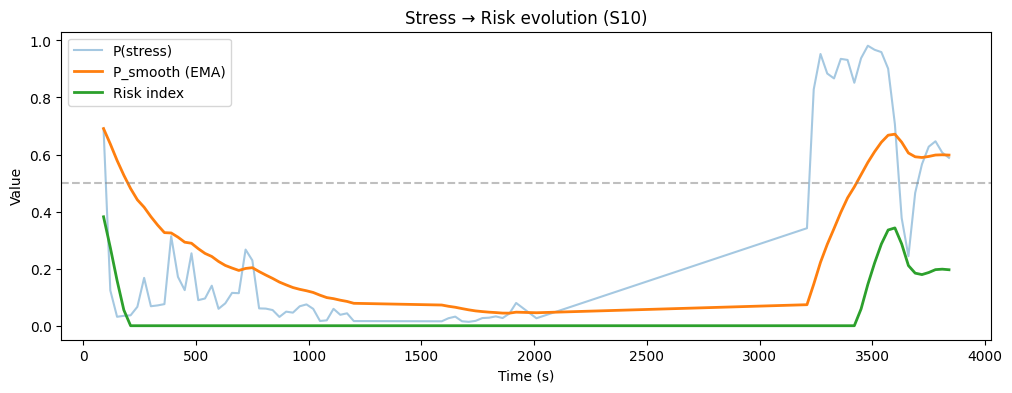

In [12]:
import matplotlib.pyplot as plt

subjects_plot = [ "S7", "S10"]

for sid in subjects_plot:
    d = res_df[res_df["subject"] == sid].sort_values("start_sec")
    if len(d) == 0:
        print(f"{sid} not found in res_df (maybe missing in dataset/windowing).")
        continue

    plt.figure(figsize=(12,4))
    plt.plot(d["start_sec"], d["p_stress"], label="P(stress)", alpha=0.4)
    plt.plot(d["start_sec"], d["p_smooth"], label="P_smooth (EMA)", linewidth=2)
    plt.plot(d["start_sec"], d["risk_index"], label="Risk index", linewidth=2)
    plt.axhline(THETA, color="gray", linestyle="--", alpha=0.5)
    plt.legend()
    plt.title(f"Stress → Risk evolution ({sid})")
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.show()
